El presente documento es un tutorial para calcular el indicador de riesgo de mercado conocido como Value at Risk (desde ahora en adelante VaR), utilizando los métodos: histórico, paramétrico y por smulación de montecarlo.

Para el cálculo y maniupalción de datos se utilizan las librerías:
- Pandas
- Numpy
- Yfinance
- Datetime
- Matplotlib
- Dateutil
- Scipy

La forma forma de importarlas se muestra a continuación.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from scipy.stats import norm, kurtosis, skew, chi2
from numpy.linalg import cholesky

# Obtener datos de mercado

Para el ejercio se utilizará un portafolio constituido por las acciones de Tesla, Apple, Facebook, Nvidia, Microsoft y Amazon, donde los tickers son respectivamente TSLA, AAPL, FB, NVDA, MSFT y AMZN. 

Para descargar los datos de mercado desde internet se utuliza la función *download()* de la librería *Yfinance*, importada como *yf*, la cual nos permite extraer datos desde **Yahoo Finance**. Para esto necesitamos los tickers de las acciones, una fecha de inicio y una de termino, estos datos deben ser datos de tipo *string*.

La descarga de datos se muestra a continuación.

In [2]:
# Get market data
tickers = ['TSLA', 'AAPL', 'FB', 'NVDA', 'MSFT', 'AMZN']
start = (dt.datetime.now() - relativedelta(years=5)).strftime('%Y-%m-%d')
df = yf.download(tickers,start)['Adj Close']

[*********************100%***********************]  6 of 6 completed


En la desacarga de datos se extraen 5 años exactos desde hoy, para estimar la fecha de 5 años atrás (inicio) se utilizan las funciones *datetime.now()* y *relativedelta* de las librerías *Datetime* y *Dateutil*. Un detalle a destacar es que si no se define una fecha de termino, está será por defecto la fecha de hoy, es por esto que no definimos fecha de termino en la función. Por último, para este ejercicio vamos a trabajar con los precios de cierre ajustados por dividendo, por lo que lo para forzar que solo nos entregue esa información agregamos "['Adj Close']".

In [8]:
# Define weights & estimate returns
weights = np.random.rand(len(tickers)) # random weights
weights /= np.sum(weights) # force total portfolio equal to one
port_ret = np.log(df/df.shift(1)).dropna() # logarithmic returns

#Get financials
ret = port_ret.mean().values
mean = np.dot(weights.T,ret)
cov = port_ret.cov()
std = np.sqrt(
        np.dot(weights.T,np.dot(cov,weights))
)
last_price = np.dot(df.iloc[-1].values,weights.T)

In [9]:
# Parametric VaR
confidence_level = norm.ppf(0.99)
time_delta = 1
VaR = mean - (confidence_level * std * np.sqrt(time_delta))
VaR_perc = VaR * 100
print('Value at Risk of Portfolio is {0:.2f}%'.format(VaR_perc))


Value at Risk of Portfolio is -4.37%


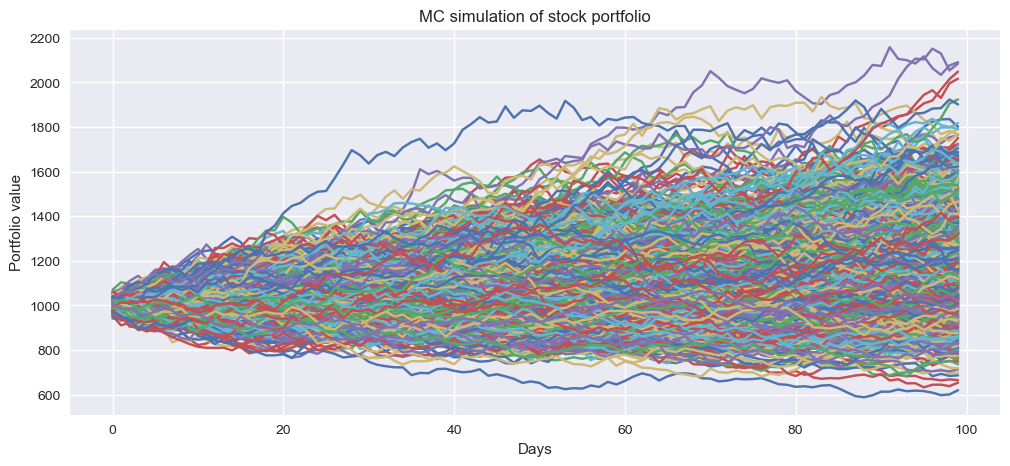

In [10]:
# Monte-Carlo simulation
simulations = 1000
T = 100
mean_mtx = np.full(shape=(T, len(weights)), fill_value=ret).T
portf_simulations = np.full(shape=(T, simulations),fill_value=0.0)
initial_portf = last_price

for i in range(0, simulations):
     Z = np.random.normal(size=(T, len(weights)))
     L = cholesky(cov)
     daily_ret = mean_mtx + np.inner(L,Z)
     portf_simulations[:,i] = np.cumprod(np.inner(weights,daily_ret.T)+1)*initial_portf

plt.figure(figsize=(12,5))
plt.style.use('seaborn')
plt.plot(portf_simulations)
plt.ylabel('Portfolio value')
plt.xlabel('Days')
plt.title('MC simulation of stock portfolio')
plt.show()

